In [13]:
import pandas as pd
import copy
import numpy as np
from datetime import datetime
import os
import re
import glob
from omegaconf import OmegaConf
from typing import List
from multiprocessing import Pool
import uncertainty_toolbox as uct
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from hydra.utils import instantiate

plt.rcParams["figure.figsize"] = [14, 5]
# sns.set(rc={'figure.figsize':(14,5)})

color_palette = {
    'MVERegression': '#1f77b4',  # Blue
    'QuantileRegression': '#ff7f0e',  # Orange
    'DKLRegression': '#2ca02c',  # Green
    'LaplaceRegresion': '#d62728',  # Red
    'DeepEnsemble': '#9467bd',  # Purple
    'MCDropoutRegression': '#8c564b',  # Brown
    'SWAGRegression': '#e377c2',  # Pink
    'BNN_VI_ELBO_Regression': '#7f7f7f',  # Gray
    'DER': '#bcbd22',  # Lime
    'DUERegression': '#17becf',  # Teal
    'BaseModel': '#aec7e8', # Light Blue
    'ConformalQR': '#ffbb78',  # Light Orange
    "CARDRegression": "#98df8a"
}

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
# specify directories to include in analysis
directories = [
    "/p/project/hai_uqmethodbox/experiment_output/test_notebook",
]
paths = [file for directory in directories for file in glob.glob(os.path.join(directory, "*", "pred*.csv"))]



# selective prediction threshold
SELECTIVE_THRESH = 9

# https://www.nhc.noaa.gov/aboutsshws.php
# wind speed is in knots in this competition
bins = [0, 82, 95, 112, 136, float('inf')]
labels = ["1", "2", "3", "4", "5"]
count_cols = ["count_1", "count_2", "count_3", "count_4", "count_5"]

In [15]:
paths

['/p/project/hai_uqmethodbox/experiment_output/test_notebook/cyclone_DKLRegression_12-06-2023_13-54-21-736682/preds_train.csv',
 '/p/project/hai_uqmethodbox/experiment_output/test_notebook/cyclone_DKLRegression_12-06-2023_13-54-21-736682/preds.csv',
 '/p/project/hai_uqmethodbox/experiment_output/test_notebook/cyclone_BNN_VI_ELBO_Regression_12-06-2023_13-54-21-737242/preds_train.csv',
 '/p/project/hai_uqmethodbox/experiment_output/test_notebook/cyclone_BNN_VI_ELBO_Regression_12-06-2023_13-54-21-737242/preds.csv',
 '/p/project/hai_uqmethodbox/experiment_output/test_notebook/cyclone_DER_12-06-2023_13-54-21-736669/preds_train.csv',
 '/p/project/hai_uqmethodbox/experiment_output/test_notebook/cyclone_DER_12-06-2023_13-54-21-736669/preds.csv',
 '/p/project/hai_uqmethodbox/experiment_output/test_notebook/cyclone_MCDropoutRegression_12-06-2023_13-54-21-736676/preds_train.csv',
 '/p/project/hai_uqmethodbox/experiment_output/test_notebook/cyclone_MCDropoutRegression_12-06-2023_13-54-21-736676/pr

## Util functions

In [16]:
def get_target_normalization_params(config):
    """Get the target normalization parameters from the datamodule
    
    Args:
        config: hydra config object

    Returns:
        tuple: (target_mean, target_std)
    """
    dm = instantiate(config.datamodule)
    return dm.target_mean.item(), dm.target_std.item()

def get_normalization_params_from_df(pred_path):
    base_dir = os.path.dirname(pred_path)
    config = OmegaConf.load(os.path.join(base_dir, 'config.yaml'))
    target_mean, target_std = get_target_normalization_params(config)
    return pd.Series([target_mean, target_std])

In [17]:
def compute_overview_df(paths):
    pattern = r"(\d{2}-\d{2}-\d{4})"
    datetime_format = "%d-%m-%Y_%H-%M-%S-%f"
    overview_df = pd.DataFrame()
    for idx, path in enumerate(paths):
        exp_dict = {}
        conf = OmegaConf.load(os.path.join(os.path.dirname(path), "config.yaml"))
        if "post_processing" in conf:
            exp_dict["uqmethod"] = conf.post_processing["_target_"].split(".")[-1]
        else:
            exp_dict["uqmethod"] = conf.uq_method["_target_"].split(".")[-1]
        
        match = re.search(pattern, path)
        date_str = match.group(1)

        # Convert string to datetime object
        date = datetime.strptime(date_str, '%m-%d-%Y')
        # exp_dict["date"] = datetime.strptime(date_string, datetime_format)
        exp_dict["pred_path"] = path
        exp_dict["conf_path"] = path.replace("predictions.csv", "config.yaml")
        exp_dict["metric_path"] = os.path.join(os.path.dirname(path), "csv_logs", "version_0", "metrics.csv")
        overview_df = pd.concat([overview_df, pd.DataFrame(exp_dict, index=[idx])])

    return overview_df

overview_df = compute_overview_df(paths)
overview_df

,uqmethod,pred_path,conf_path,metric_path
0,DKLRegression,/p/project/hai_uqmethodbox/experiment_output/t...,/p/project/hai_uqmethodbox/experiment_output/t...,/p/project/hai_uqmethodbox/experiment_output/t...
1,DKLRegression,/p/project/hai_uqmethodbox/experiment_output/t...,/p/project/hai_uqmethodbox/experiment_output/t...,/p/project/hai_uqmethodbox/experiment_output/t...
2,BNN_VI_ELBO_Regression,/p/project/hai_uqmethodbox/experiment_output/t...,/p/project/hai_uqmethodbox/experiment_output/t...,/p/project/hai_uqmethodbox/experiment_output/t...
3,BNN_VI_ELBO_Regression,/p/project/hai_uqmethodbox/experiment_output/t...,/p/project/hai_uqmethodbox/experiment_output/t...,/p/project/hai_uqmethodbox/experiment_output/t...
4,DER,/p/project/hai_uqmethodbox/experiment_output/t...,/p/project/hai_uqmethodbox/experiment_output/t...,/p/project/hai_uqmethodbox/experiment_output/t...
5,DER,/p/project/hai_uqmethodbox/experiment_output/t...,/p/project/hai_uqmethodbox/experiment_output/t...,/p/project/hai_uqmethodbox/experiment_output/t...
6,MCDropoutRegression,/p/project/hai_uqmethodbox/experiment_output/t...,/p/project/hai_uqmethodbox/experiment_output/t...,/p/project/hai_uqmethodbox/experiment_output/t...
7,MCDropoutRegression,/p/project/hai_uqmethodbox/experiment_output/t...,/p/project/hai_uqmethodbox/experiment_output/t...,/p/project/hai_uqmethodbox/experiment_output/t...


In [72]:
empty_result = {'accuracy': {'mae': np.nan, 'rmse': np.nan, 'mdae': np.nan, 'marpd': np.nan, 'r2': np.nan, 'corr': np.nan}, 'avg_calibration': {'rms_cal': np.nan, 'ma_cal': np.nan, 'miscal_area': np.nan}, 'sharpness': {'sharp': np.nan}, 'scoring_rule': {'nll': np.nan, 'crps': np.nan, 'check': np.nan, 'interval': np.nan}}
def compute_metrics_for_predictions(csv_path: str, selective_pred: bool, normalized: bool = False) -> pd.DataFrame:
    """Compute metrics for prediction file.

    Args:
        save_dir: path_to_csv
        selective_pred: whether or not to apply selective prediction

    Returns:
        dataframe with computed metrics
    """
    pred_df = pd.read_csv(csv_path)

    # get normalization parameters
    TARGET_MEAN, TARGET_STD = get_target_normalization_params(OmegaConf.load(os.path.join(os.path.dirname(csv_path), "config.yaml")))
                                                              
    # unnormalize data
    if not normalized:
        pred_df["pred"] = (pred_df["pred"] * TARGET_STD) + TARGET_MEAN
        pred_df["target"] = (pred_df["target"] * TARGET_STD) + TARGET_MEAN

    pred_df['storm_category'] = pd.cut(pred_df['target'], bins=bins, labels=labels, right=False)
    # count number of observations per category
    count_per_cat = pred_df.groupby("storm_category")["pred"].count()

    if "pred_uct" in pred_df.columns:

        if not normalized:
            pred_df["pred_uct"] = pred_df["pred_uct"] * TARGET_STD

        if selective_pred:
            # Filter the DataFrame to exclude the top 10% highest values
            pred_df = pred_df[pred_df["pred_uct"] <= SELECTIVE_THRESH]
            # number of observations per category afterwards
            count_per_cat = pred_df.groupby("storm_category")["pred"].count()

        if len(pred_df) > 0:  
            uq_metrics = uct.metrics.get_all_metrics(
                pred_df["pred"].values.squeeze(),
                pred_df["pred_uct"].values.squeeze(),
                pred_df["target"].values.squeeze(),
                verbose=False,
            )
        else:
            # TODO: What to do if all metrics are removed
            uq_metrics = empty_result
        # categories when predictive uncertainty is present
        uq_metric_categories = ["scoring_rule", "avg_calibration", "sharpness", "accuracy"]

    else:
        # categories when no predictive uncertainty is present
        uq_metric_categories = ["accuracy"]
        uq_metrics = {"accuracy": uct.metrics.get_all_accuracy_metrics(pred_df["pred"].values.squeeze(), pred_df["target"].values.squeeze())}

    # collect metrics
    metrics_dict = {uq_cat: uq_metrics[uq_cat] for uq_cat in uq_metric_categories}

    # mulit column df holding the results
    df = pd.DataFrame.from_dict(metrics_dict, orient="index").stack().to_frame().T

    # drop multilevel
    df.columns = df.columns.droplevel(0)

    # case if empty results have to handle manually since dict of nan just creates empty df
    if df.empty:
        # Flatten the dictionary keys
        flattened_keys = [f'{inner_key}' for outer_key, inner_dict in empty_result.items() for inner_key in inner_dict.keys()]
        # Create DataFrame
        df = pd.DataFrame(columns=flattened_keys)
        # Fill DataFrame with NaNs
        df.loc[0] = np.nan

    df["split"] = csv_path.split(os.sep)[-1].split(".")[0]
    df["pred_path"] = csv_path

    # count 
    count_df = pd.DataFrame(count_per_cat).transpose().reset_index()
    count_df = count_df[["1", "2", "3", "4", "5"]]
    count_df.columns = count_cols
    count_df["count_total"] = count_df.sum(axis=1)
    df = pd.concat([df, count_df], axis=1)

    return df

In [73]:
def compute_uncertainty_df(overview_df):
    def parallel_process(paths: List[str], num_processes: int, selective_pred: bool, normalised: bool):
        # Create a multiprocessing pool with the specified number of processes
        pool = Pool(processes=num_processes)
        # Map the paths to the process_path function and execute in parallel
        result_dfs = pool.starmap(compute_metrics_for_predictions, [(path, selective_pred, normalised) for path in paths])
        # Close the pool of processes
        pool.close()
        # Combine the resulting DataFrames into a single DataFrame
        combined_df = pd.concat(result_dfs, ignore_index=True)
        return combined_df

    # Assuming 'df' is your original DataFrame with the path column
    # Extract the paths from the DataFrame column
    paths = overview_df['pred_path'].tolist()

    # Specify the number of processes to use for parallel execution
    num_processes = 8  # Adjust according to your system capabilities

    # Call the parallel_process function to execute the processing in parallel
    uqmetric_df = parallel_process(paths, num_processes, selective_pred=False, normalised=False)
    selective_df = parallel_process(paths, num_processes, selective_pred=True, normalised=False)

    # merge model name column
    uqmetric_df = pd.merge(left=uqmetric_df, right=overview_df[["pred_path", "uqmethod"]], how="left", left_on="pred_path", right_on="pred_path")
    selective_df = pd.merge(left=selective_df, right=overview_df[["pred_path", "uqmethod"]], how="left", left_on="pred_path", right_on="pred_path")

    return uqmetric_df, selective_df


uq_metric_df, selective_df = compute_uncertainty_df(overview_df)

uq_metric_df, selective_df

/tmp/ipykernel_10267/4250725360.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  count_per_cat = pred_df.groupby("storm_category")["pred"].count()
/tmp/ipykernel_10267/4250725360.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  count_per_cat = pred_df.groupby("storm_category")["pred"].count()
/tmp/ipykernel_10267/4250725360.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  count_per_cat = pred_df.groupby("stor

(        nll       crps     check    interval   rms_cal    ma_cal  miscal_area  \
 0  4.847445  17.283991  8.727702   85.534170  0.054292  0.039935     0.040046   
 1  4.542004  11.641957  5.877869   60.176650  0.162095  0.129399     0.130061   
 2  4.899202  16.182873  8.171222   78.970981  0.197524  0.177012     0.178800   
 3  4.180170   8.909858  4.499067   42.863009  0.031998  0.026276     0.026461   
 4  5.101565  18.215222  9.196636  105.309718  0.282471  0.244421     0.246874   
 5  5.029917  15.091587  7.619090   96.505699  0.401851  0.344108     0.347581   
 6  4.653915  14.225387  7.183075   69.667468  0.062079  0.046774     0.047202   
 7  4.413983   9.472114  4.782398   52.707647  0.218633  0.185332     0.187204   
 
        sharp        mae       rmse  ...      corr        split  \
 0  31.199040  24.627250  30.826138  ... -0.093484  preds_train   
 1  31.199040  17.400239  18.858183  ...  0.132025        preds   
 2  19.701872  22.905331  27.118443  ...  0.059509  preds_t

In [74]:
with pd.option_context('display.max_colwidth', None):
    display(uq_metric_df[uq_metric_df["uqmethod"]=="BNN_VI_ELBO_Regression"][["rmse", "pred_path","split"]])

,rmse,pred_path,split
2,27.118443,/p/project/hai_uqmethodbox/experiment_output/test_notebook/cyclone_BNN_VI_ELBO_Regression_12-06-2023_13-54-21-737242/preds_train.csv,preds_train
3,15.359018,/p/project/hai_uqmethodbox/experiment_output/test_notebook/cyclone_BNN_VI_ELBO_Regression_12-06-2023_13-54-21-737242/preds.csv,preds


# Diff Selective Prediction Effect

This Table shows the performance improvement in metrics after applying selective prediction.

In [81]:
diff_df = pd.DataFrame()

# Iterate over each column in the dataframes
for column in uq_metric_df.columns:
    # Check if the column contains numerical values
    if pd.api.types.is_numeric_dtype(uq_metric_df[column]):
        # Assign the difference to the new dataframe
        diff_df[column] = uq_metric_df[column] - selective_df[column]
    else:
        # If the column contains non-numerical values, assign the values from df1 to the new dataframe
        diff_df[column] = uq_metric_df[column]

display(diff_df[diff_df["split"]=="preds"][["uqmethod", "split", "nll", "sharp", "mae", "rmse", "pred_path"]])

,uqmethod,split,nll,sharp,mae,rmse,pred_path
1,DKLRegression,preds,NaN,NaN,NaN,NaN,/p/project/hai_uqmethodbox/experiment_output/t...
3,BNN_VI_ELBO_Regression,preds,NaN,NaN,NaN,NaN,/p/project/hai_uqmethodbox/experiment_output/t...
5,DER,preds,NaN,NaN,NaN,NaN,/p/project/hai_uqmethodbox/experiment_output/t...
7,MCDropoutRegression,preds,NaN,NaN,NaN,NaN,/p/project/hai_uqmethodbox/experiment_output/t...


([0, 1, 2, 3],
 [Text(0, 0, 'DKLRegression'),
  Text(1, 0, 'BNN_VI_ELBO_Regression'),
  Text(2, 0, 'DER'),
  Text(3, 0, 'MCDropoutRegression')])

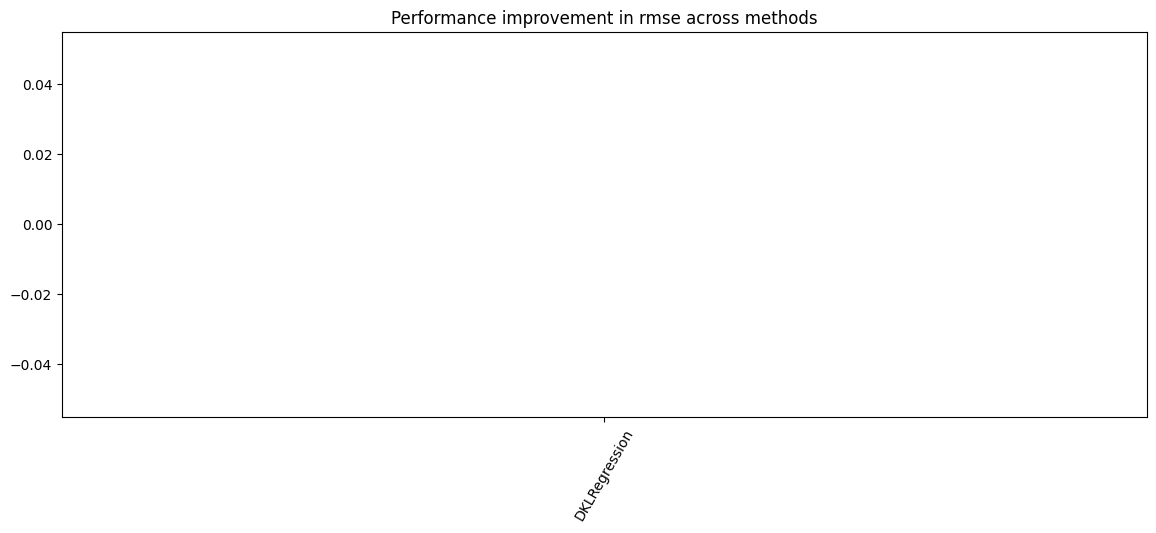

In [82]:
metric = "rmse"
diff_train = diff_df[diff_df["split"]=="preds_train"].reset_index(drop=True)
diff_test = diff_df[diff_df["split"]=="preds"].reset_index(drop=True)
fig, ax = plt.subplots(1)
ax.bar(diff_test["uqmethod"].values, diff_test[metric].values)
plt.title(f"Performance improvement in {metric} across methods")
plt.xticks(rotation=60)

The number of samples being removed per category as a percentage.

In [83]:
sample_remain_pct = (uq_metric_df[count_cols+["count_total"]] - selective_df[count_cols+["count_total"]]) / uq_metric_df[count_cols+["count_total"]]
sample_remain_pct.insert(0, ("split"), uq_metric_df["split"])
sample_remain_pct.insert(0, ("UQ Method"), uq_metric_df["uqmethod"])

([0, 1, 2, 3],
 [Text(0, 0, 'DKLRegression'),
  Text(1, 0, 'BNN_VI_ELBO_Regression'),
  Text(2, 0, 'DER'),
  Text(3, 0, 'MCDropoutRegression')])

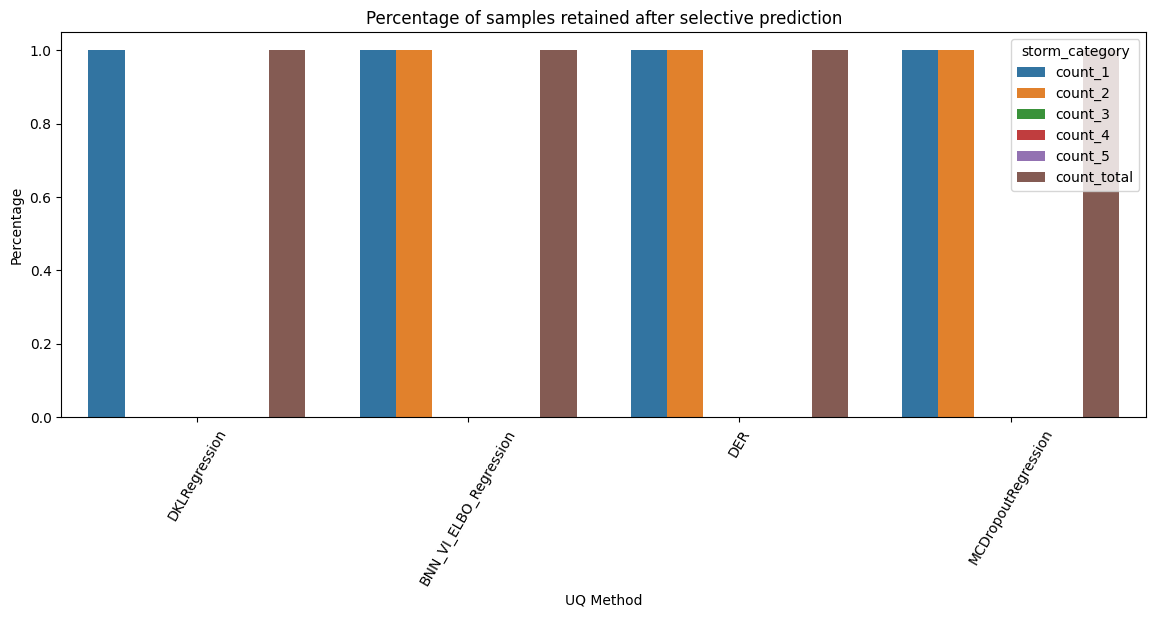

In [84]:
train_count = sample_remain_pct[sample_remain_pct["split"]=="preds_train"].reset_index(drop=True)
train_count = pd.melt(train_count, id_vars="UQ Method", value_vars=count_cols+["count_total"], var_name="storm_category")
test_count = sample_remain_pct[sample_remain_pct["split"]=="preds"].reset_index(drop=True)
test_count = pd.melt(test_count, id_vars="UQ Method", value_vars=count_cols+["count_total"], var_name="storm_category")
fig, ax = plt.subplots(1)
sns.barplot(x="UQ Method", y="value", hue="storm_category", data=test_count)
plt.ylabel("Percentage")
plt.title("Percentage of samples retained after selective prediction")
plt.xticks(rotation=60)

# All preds in a single DF

In [87]:
overview_df["split"] = overview_df["pred_path"].str.split(os.sep, expand=True)[7]
# test_df = overview_df[overview_df["split"]=="predictions.csv"].reset_index(drop=True)

all_test_pred_df = []
for idx, row in overview_df.iterrows():
    pred_df = pd.read_csv(row["pred_path"])
    pred_df["uqmethod"] = row["uqmethod"]
    pred_df["split"] = row["split"]
    pred_df["pred_path"] = row["pred_path"]
    all_test_pred_df.append(pred_df)

from scipy import stats
# test_df = overview_df[overview_df["split"]=="predictions"]

all_test_pred_df = pd.concat(all_test_pred_df, ignore_index=True)

# get normalization parameters and put them into df columns
# no apply them to the df
all_test_pred_df['base_dir'] = all_test_pred_df['pred_path'].apply(os.path.dirname)
grouped = all_test_pred_df.groupby('base_dir')['pred_path'].first().apply(get_normalization_params_from_df)
grouped_df = grouped.reset_index()
grouped_df.columns = ['base_dir', 'target_mean', 'target_std']
all_test_pred_df = pd.merge(all_test_pred_df, grouped_df, on='base_dir', how='left')
all_test_pred_df = all_test_pred_df.drop(columns='base_dir')
# all_test_pred_df[["target_mean", "target_std"]] = all_test_pred_df["pred_path"].apply(get_normalization_params_from_df)


# normalize
all_test_pred_df["pred"] = (all_test_pred_df["pred"] * all_test_pred_df["target_std"]) + all_test_pred_df["target_mean"]
all_test_pred_df["target"] = (all_test_pred_df["target"] * all_test_pred_df["target_std"]) + all_test_pred_df["target_mean"]
all_test_pred_df["pred_uct"] = all_test_pred_df["pred_uct"] * all_test_pred_df["target_std"]

all_test_pred_df['storm_category'] = pd.cut(all_test_pred_df['target'], bins=bins, labels=labels, right=False)
all_test_pred_df["mse"] = (all_test_pred_df["pred"] - all_test_pred_df["target"])**2
all_test_pred_df["mae"] = np.abs(all_test_pred_df["pred"] - all_test_pred_df["target"])
all_test_pred_df["nll"] = -1 * stats.norm.logpdf(all_test_pred_df["pred"] - all_test_pred_df["target"], scale=all_test_pred_df["pred_uct"])

# date
pattern = r"(\d{2}-\d{2}-\d{4}_\d{2}-\d{2}-\d{6})"

# Extract dates and create a new column
all_test_pred_df['date'] = all_test_pred_df['pred_path'].str.extract(pattern)

# Convert the new_date_column to datetime format
all_test_pred_df['date'] = pd.to_datetime(all_test_pred_df['date'], format='%m-%d-%Y_%H-%M')

all_test_pred_df

,pred,pred_uct,epistemic_uct,target,uqmethod,split,pred_path,aleatoric_uct,target_mean,target_std,storm_category,mse,mae,nll,date
0,52.009599,31.199040,1.177495,80.000000,DKLRegression,preds_train.csv,/p/project/hai_uqmethodbox/experiment_output/t...,NaN,52.007515,26.496117,1,783.462509,27.990400,4.761770,NaT
1,52.009599,31.199040,1.177495,113.999999,DKLRegression,preds_train.csv,/p/project/hai_uqmethodbox/experiment_output/t...,NaN,52.007515,26.496117,4,3842.809692,61.990400,6.333277,NaT
2,52.009599,31.199040,1.177495,39.000000,DKLRegression,preds_train.csv,/p/project/hai_uqmethodbox/experiment_output/t...,NaN,52.007515,26.496117,1,169.249678,13.009599,4.446265,NaT
3,52.009599,31.199040,1.177495,67.000001,DKLRegression,preds_train.csv,/p/project/hai_uqmethodbox/experiment_output/t...,NaN,52.007515,26.496117,1,224.712130,14.990401,4.474755,NaT
4,52.009599,31.199040,1.177495,25.000002,DKLRegression,preds_train.csv,/p/project/hai_uqmethodbox/experiment_output/t...,NaN,52.007515,26.496117,1,729.518352,27.009597,4.734060,NaT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3323,59.036352,30.099962,NaN,74.000001,MCDropoutRegression,preds.csv,/p/project/hai_uqmethodbox/experiment_output/t...,1.136014,52.007515,26.496117,1,223.910784,14.963649,4.447032,NaT
3324,59.583260,30.257998,NaN,75.000000,MCDropoutRegression,preds.csv,/p/project/hai_uqmethodbox/experiment_output/t...,1.141979,52.007515,26.496117,1,237.675865,15.416740,4.458499,NaT
3325,59.955779,30.362965,NaN,76.000000,MCDropoutRegression,preds.csv,/p/project/hai_uqmethodbox/experiment_output/t...,1.145940,52.007515,26.496117,1,257.417030,16.044221,4.471773,NaT
3326,60.804650,30.621626,NaN,77.000001,MCDropoutRegression,preds.csv,/p/project/hai_uqmethodbox/experiment_output/t...,1.155702,52.007515,26.496117,1,262.289383,16.195351,4.480505,NaT


In [88]:
all_test_pred_df[all_test_pred_df["pred_uct"].isna()]

,pred,pred_uct,epistemic_uct,target,uqmethod,split,pred_path,aleatoric_uct,target_mean,target_std,storm_category,mse,mae,nll,date


## Dataframe with Metrics per Category

In [90]:
group_cols = ["uqmethod", "pred_path", "storm_category"]
category_df = all_test_pred_df.groupby(by=group_cols)[["mse", "mae", "nll", "pred_uct"]].mean()
category_df.reset_index(inplace=True)
category_df.rename(columns={"pred_uct": "sharpness"}, inplace=True)
category_df["rmse"] = category_df["mse"] ** 0.5
category_df['split'] = category_df['pred_path'].str.rsplit('/', n=1).str[-1].str.rsplit(".").str[0]
category_df["contains"] = [x[0] in x[1] for x in zip(category_df['uqmethod'], category_df['pred_path'])]
category_df = category_df[category_df["contains"]==True]

category_df = category_df[~((category_df['uqmethod'] == 'MCDropoutRegression') & category_df['rmse'].isna())]
category_df = category_df[~((category_df['uqmethod'] == 'DKLRegression') & category_df['rmse'].isna())]
# category_df = category_df[~((category_df['uqmethod'] == 'BaseModel') & category_df['rmse'].isna())]

del category_df["contains"]
# compute other metrics of interest
quantile = 0.95
result = all_test_pred_df[all_test_pred_df["uqmethod"]!="BaseModel"].groupby(group_cols).apply(lambda x: uct.get_proportion_in_interval(x["pred"].values, x['pred_uct'].values, x['target'].values, quantile=quantile)).reset_index()
result.rename(columns={0: f"proportion_in_{quantile}_interval"}, inplace=True)

category_df = pd.merge(category_df, result, how="left", left_on=group_cols, right_on=group_cols)

category_df

/tmp/ipykernel_10267/538438380.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  category_df = all_test_pred_df.groupby(by=group_cols)[["mse", "mae", "nll", "pred_uct"]].mean()
/tmp/ipykernel_10267/538438380.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  result = all_test_pred_df[all_test_pred_df["uqmethod"]!="BaseModel"].groupby(group_cols).apply(lambda x: uct.get_proportion_in_interval(x["pred"].values, x['pred_uct'].values, x['target'].values, quantile=quantile)).reset_index()


,uqmethod,pred_path,storm_category,mse,mae,nll,sharpness,rmse,split,proportion_in_0.95_interval
0,BNN_VI_ELBO_Regression,/p/project/hai_uqmethodbox/experiment_output/t...,1,230.017890,12.487881,4.169393,17.488456,15.166341,preds,0.998016
1,BNN_VI_ELBO_Regression,/p/project/hai_uqmethodbox/experiment_output/t...,2,606.436773,24.591595,4.859120,16.211669,24.625937,preds,1.000000
2,BNN_VI_ELBO_Regression,/p/project/hai_uqmethodbox/experiment_output/t...,3,NaN,NaN,NaN,NaN,NaN,preds,NaN
3,BNN_VI_ELBO_Regression,/p/project/hai_uqmethodbox/experiment_output/t...,4,NaN,NaN,NaN,NaN,NaN,preds,NaN
4,BNN_VI_ELBO_Regression,/p/project/hai_uqmethodbox/experiment_output/t...,5,NaN,NaN,NaN,NaN,NaN,preds,NaN
5,BNN_VI_ELBO_Regression,/p/project/hai_uqmethodbox/experiment_output/t...,1,472.326046,19.184454,4.605149,18.734280,21.733063,preds_train,0.913043
6,BNN_VI_ELBO_Regression,/p/project/hai_uqmethodbox/experiment_output/t...,2,834.912407,28.685444,5.202629,18.482274,28.894851,preds_train,0.730769
7,BNN_VI_ELBO_Regression,/p/project/hai_uqmethodbox/experiment_output/t...,3,2001.337047,44.439001,6.903967,19.231787,44.736306,preds_train,0.214286
8,BNN_VI_ELBO_Regression,/p/project/hai_uqmethodbox/experiment_output/t...,4,3697.209048,60.412325,7.930096,24.410644,60.804679,preds_train,0.263158
9,BNN_VI_ELBO_Regression,/p/project/hai_uqmethodbox/experiment_output/t...,5,11065.642520,102.987566,8.345026,37.366375,105.193358,preds_train,0.000000


In [91]:
with pd.option_context('display.max_colwidth', None):
    display(category_df[category_df["uqmethod"]=="DKLRegression"])


,uqmethod,pred_path,storm_category,mse,mae,nll,sharpness,rmse,split,proportion_in_0.95_interval
20,DKLRegression,/p/project/hai_uqmethodbox/experiment_output/test_notebook/cyclone_DKLRegression_12-06-2023_13-54-21-736682/preds.csv,1,355.631052,17.400239,4.542004,31.19904,18.858183,preds,1.000000
21,DKLRegression,/p/project/hai_uqmethodbox/experiment_output/test_notebook/cyclone_DKLRegression_12-06-2023_13-54-21-736682/preds_train.csv,1,352.862125,16.691545,4.540582,31.19904,18.784625,preds_train,1.000000
22,DKLRegression,/p/project/hai_uqmethodbox/experiment_output/test_notebook/cyclone_DKLRegression_12-06-2023_13-54-21-736682/preds_train.csv,2,1505.831061,38.561830,5.132832,31.19904,38.805039,preds_train,1.000000
23,DKLRegression,/p/project/hai_uqmethodbox/experiment_output/test_notebook/cyclone_DKLRegression_12-06-2023_13-54-21-736682/preds_train.csv,3,2756.710538,52.276115,5.775376,31.19904,52.504386,preds_train,1.000000
24,DKLRegression,/p/project/hai_uqmethodbox/experiment_output/test_notebook/cyclone_DKLRegression_12-06-2023_13-54-21-736682/preds_train.csv,4,4650.197750,67.823734,6.748011,31.19904,68.192358,preds_train,0.083333


In [92]:
# Make latex table
category_columns = ["rmse", "nll"]
splits = category_df["storm_category"].unique()

columns = pd.MultiIndex.from_product([splits, category_columns])
combined_df = pd.DataFrame(columns=columns)

latex_df = category_df[category_df["split"]=="predictions"]

# combined_df["uqmethod"] = tail_and_gap_selective_df["uqmethod"].unique()
for split in splits:
    split_df = latex_df[latex_df["storm_category"]==split]
    for metric in category_columns:
        combined_df[(split, metric)] = split_df[metric].values
    # print(combined_df)

combined_df.insert(0, ("", "uqmethod"), latex_df["uqmethod"].unique())
combined_df= combined_df.round(3)
# print(combined_df)

def as_latex_output(combined_df):
    combined_df = combined_df.round(3)
    # print(combined_df.max())
    max_values = combined_df.max()
    min_values = combined_df.min()
    latex_output = combined_df.to_latex(escape=False, index=False, float_format="%.3f")

    for column in max_values.index:
        if "diff" in column:
            latex_output = latex_output.replace(
                str(max_values[column]), "\\textbf{" + str(max_values[column]) + "}"
            )
        else:
            latex_output = latex_output.replace(
                str(min_values[column]), "\\textbf{" + str(min_values[column]) + "}"
            )
        # latex_column = column.replace("_", "\\_")
        # latex_output = latex_output.replace(column, latex_column)

    latex_output = latex_output.replace("_", "\\_")
    latex_output = latex_output.replace("\multicolumn{3}{r}", "\multicolumn{3}{c}")
    latex_output = latex_output.replace("rmse", "rmse $\downarrow$")
    latex_output = latex_output.replace("nll", "nll $\downarrow$")
    # latex_output = latex_output.replace("down", "up")
    latex_output = latex_output.replace("default", "default $\downarrow$")
    latex_output = latex_output.replace("selective", "selective $\downarrow$")
    latex_output = latex_output.replace("Model", "")
    latex_output = latex_output.replace("{lrrrrrrrrrr}", "l|cc|cc|cc|cc|cc")
    latex_output = latex_output.replace("\multicolumn{2}{r}", "\multicolumn{2}{c}")
    latex_output = latex_output.replace("\textbf{BNN\_VI\_ELBO}", "BNN\_VI\_ELBO")
    return latex_output

latex_table = as_latex_output(combined_df)
print(latex_table)

\begin{tabular}l|cc|cc|cc|cc|cc
\toprule
 & \multicolumn{2}{c}{1} & \multicolumn{2}{c}{2} & \multicolumn{2}{c}{3} & \multicolumn{2}{c}{4} & \multicolumn{2}{c}{5} \\
uqmethod & rmse $\downarrow$ & nll $\downarrow$ & rmse $\downarrow$ & nll $\downarrow$ & rmse $\downarrow$ & nll $\downarrow$ & rmse $\downarrow$ & nll $\downarrow$ & rmse $\downarrow$ & nll $\downarrow$ \\
\midrule
\bottomrule
\end{tabular}



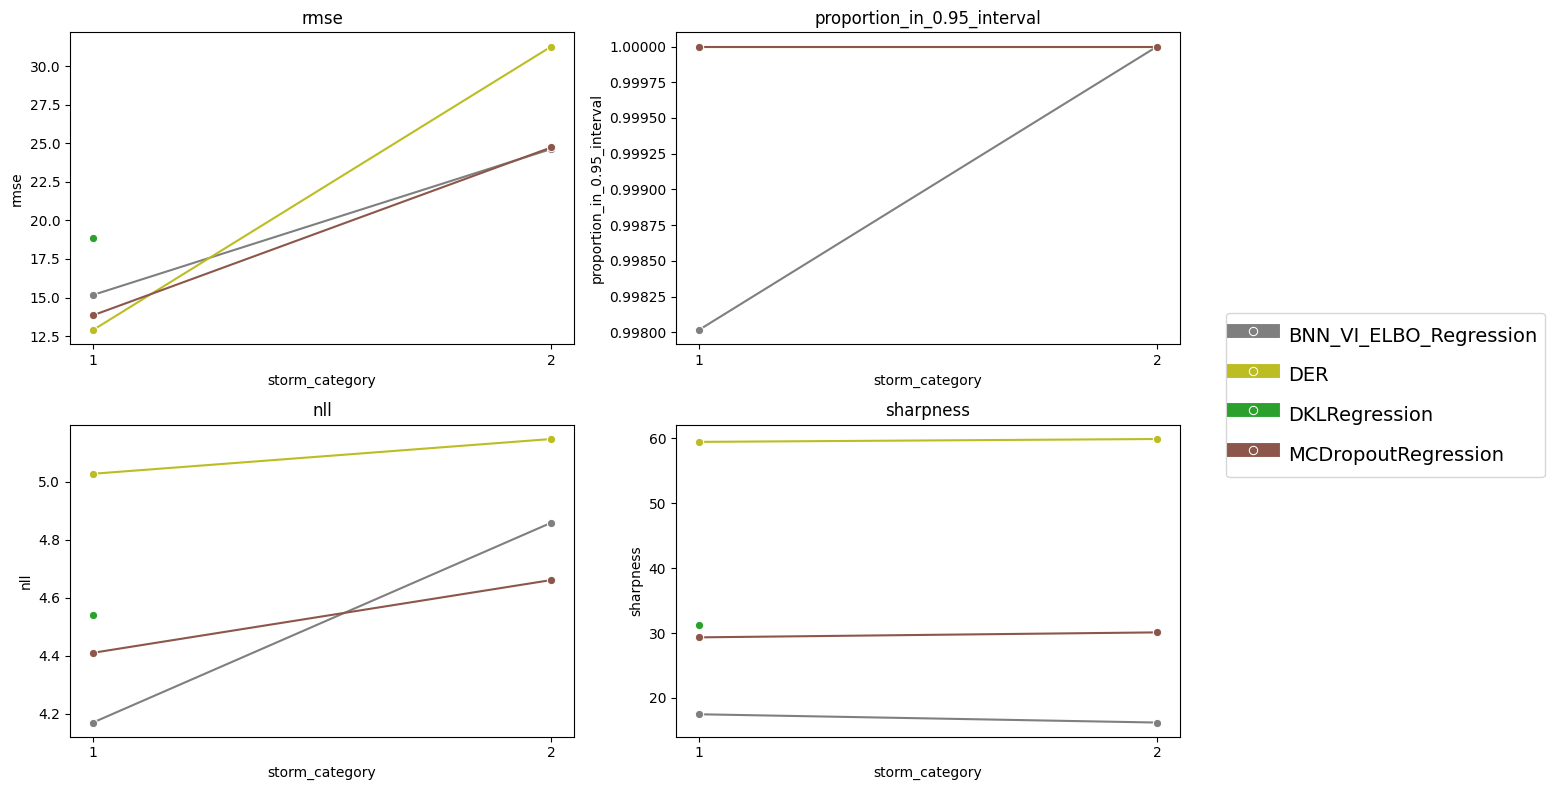

In [93]:
split = "test"

if split == "train":
    plot_cat_df = category_df[category_df["split"] == "preds_train"]
else:
    plot_cat_df = category_df[category_df["split"] == "preds"]
# plot per category
fig, axes = plt.subplots(2, 2, figsize=(12,8))

# Assuming 'category' is the column used for x-axis and 'metrics' are the columns to be plotted
metrics = ["rmse", "proportion_in_0.95_interval", "nll", "sharpness"]

# Assuming 'methods' is the column used for hue
methods = 'u'
plot_cat_df = plot_cat_df[plot_cat_df["uqmethod"]!="DERModel"]

# Loop through the subplots
for i, metric in enumerate(metrics):
    row = i // 2
    col = i % 2
    
    # Create the sns plot
    sns.lineplot(x='storm_category', y=metric, hue="uqmethod", data=plot_cat_df, ax=axes[row, col], marker="o", palette=color_palette)
    
    # Add title
    axes[row, col].set_title(f'{metric}')
    
    # Add legend
    # axes[row, col].legend(loc='upper right')

# set the linewidths to the copies
handles, labels = axes[0,0].get_legend_handles_labels()
[ha.set_linewidth(10) for ha in handles]

    
fig.legend(handles, labels, loc='center right', bbox_to_anchor=(1.3, 0.5), fontsize=14, handleheight=2)
    
# Remove individual legends
for ax in axes.flat:
    ax.get_legend().remove()

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

# Tables

In [94]:
uq_metric_df

,nll,crps,check,interval,rms_cal,ma_cal,miscal_area,sharp,mae,rmse,...,corr,split,pred_path,count_1,count_2,count_3,count_4,count_5,count_total,uqmethod
0,4.847445,17.283991,8.727702,85.534170,0.054292,0.039935,0.040046,31.199040,24.627250,30.826138,...,-0.093484,preds_train,/p/project/hai_uqmethodbox/experiment_output/t...,102,7,7,12,0,128,DKLRegression
1,4.542004,11.641957,5.877869,60.176650,0.162095,0.129399,0.130061,31.199040,17.400239,18.858183,...,0.132025,preds,/p/project/hai_uqmethodbox/experiment_output/t...,128,0,0,0,0,128,DKLRegression
2,4.899202,16.182873,8.171222,78.970981,0.197524,0.177012,0.178800,19.701872,22.905331,27.118443,...,0.059509,preds_train,/p/project/hai_uqmethodbox/experiment_output/t...,437,26,28,19,2,512,BNN_VI_ELBO_Regression
3,4.180170,8.909858,4.499067,42.863009,0.031998,0.026276,0.026461,17.633768,12.677001,15.359018,...,0.385179,preds,/p/project/hai_uqmethodbox/experiment_output/t...,504,8,0,0,0,512,BNN_VI_ELBO_Regression
4,5.101565,18.215222,9.196636,105.309718,0.282471,0.244421,0.246874,59.577190,20.245622,26.220161,...,0.462468,preds_train,/p/project/hai_uqmethodbox/experiment_output/t...,442,27,17,24,2,512,DER
5,5.029917,15.091587,7.619090,96.505699,0.401851,0.344108,0.347581,59.478754,11.494400,13.375058,...,0.335824,preds,/p/project/hai_uqmethodbox/experiment_output/t...,504,8,0,0,0,512,DER
6,4.653915,14.225387,7.183075,69.667468,0.062079,0.046774,0.047202,29.605687,20.691820,25.020554,...,0.354775,preds_train,/p/project/hai_uqmethodbox/experiment_output/t...,431,35,25,19,2,512,MCDropoutRegression
7,4.413983,9.472114,4.782398,52.707647,0.218633,0.185332,0.187204,29.374162,12.126633,14.080898,...,0.374606,preds,/p/project/hai_uqmethodbox/experiment_output/t...,504,8,0,0,0,512,MCDropoutRegression


In [96]:
category_columns = ["rmse", "nll"]
splits = ["Train", "Test"]

columns = pd.MultiIndex.from_product([splits, category_columns, ["default", "selective", "diff"]])
combined_df = pd.DataFrame(columns=columns)

# combined_df["uqmethod"] = tail_and_gap_selective_df["uqmethod"].unique()
for split in splits:
    if "train" in split.lower():
        table_uq_df = uq_metric_df[uq_metric_df["split"]=="preds"]
        table_selective_df = selective_df[selective_df["split"]=="preds"]
    else:
        table_uq_df = uq_metric_df[uq_metric_df["split"]=="predictions"]
        table_selective_df = selective_df[selective_df["split"]=="predictions"]

    table_uq_df = table_uq_df.groupby("uqmethod")[category_columns].mean().reset_index()
    table_selective_df = table_selective_df.groupby("uqmethod")[category_columns].mean().reset_index()

    for metric in category_columns:
        combined_df[(split, metric, "default")] = table_uq_df[metric]
        combined_df[(split, metric, "selective")] = table_selective_df[metric]
        combined_df[(split, metric, "diff")] = table_uq_df[metric] - table_selective_df[metric]


combined_df.insert(0, ("", "", "uqmethod"), table_uq_df["uqmethod"])
combined_df= combined_df.round(4)

def as_latex_output(combined_df):
    combined_df = combined_df.round(4)
    # print(combined_df.max())
    max_values = combined_df.max()
    min_values = combined_df.min()
    latex_output = combined_df.to_latex(escape=False, index=False, float_format="%.4f")

    for column in max_values.index:
        if "diff" in column:
            latex_output = latex_output.replace(
                str(max_values[column]), "\\textbf{" + str(max_values[column]) + "}"
            )
        else:
            latex_output = latex_output.replace(
                str(min_values[column]), "\\textbf{" + str(min_values[column]) + "}"
            )
        # latex_column = column.replace("_", "\\_")
        # latex_output = latex_output.replace(column, latex_column)

    latex_output = latex_output.replace("_", "\\_")
    latex_output = latex_output.replace("\multicolumn{3}{r}", "\multicolumn{3}{c}")
    latex_output = latex_output.replace("diff", "diff $\downarrow$")
    latex_output = latex_output.replace("down", "up")
    latex_output = latex_output.replace("default", "default $\downarrow$")
    latex_output = latex_output.replace("selective", "selective $\downarrow$")
    latex_output = latex_output.replace("Model", "")
    latex_output = latex_output.replace("{lrrrrrrrrrrrr}", "{lccc|ccc|ccc|ccc}")
    latex_output = latex_output.replace("\multicolumn{6}{r}{Train}", "\multicolumn{6}{c}{Train}")
    latex_output = latex_output.replace("\multicolumn{6}{r}{Test}", "\multicolumn{6}{c}{Test}")
    return latex_output

latex_table = as_latex_output(combined_df)
print(latex_table)

\begin{tabular}{lccc|ccc|ccc|ccc}
\toprule
 & \multicolumn{6}{c}{Train} & \multicolumn{6}{c}{Test} \\
 & \multicolumn{3}{c}{rmse} & \multicolumn{3}{c}{nll} & \multicolumn{3}{c}{rmse} & \multicolumn{3}{c}{nll} \\
uqmethod & default $\downarrow$ & selective $\downarrow$ & diff $\uparrow$ & default $\downarrow$ & selective $\downarrow$ & diff $\uparrow$ & default $\downarrow$ & selective $\downarrow$ & diff $\uparrow$ & default $\downarrow$ & selective $\downarrow$ & diff $\uparrow$ \\
\midrule
NaN & 15.3590 & NaN & NaN & \textbf{4.1802} & NaN & NaN & NaN & NaN & NaN & NaN & NaN & NaN \\
NaN & \textbf{13.3751} & NaN & NaN & 5.0299 & NaN & NaN & NaN & NaN & NaN & NaN & NaN & NaN \\
NaN & 18.8582 & NaN & NaN & 4.5420 & NaN & NaN & NaN & NaN & NaN & NaN & NaN & NaN \\
NaN & 14.0809 & NaN & NaN & 4.4140 & NaN & NaN & NaN & NaN & NaN & NaN & NaN & NaN \\
\bottomrule
\end{tabular}



## Metric Computation per Category

In [97]:
category_columns = ["rmse", "nll", "sharpness"]
splits = [""]

columns = pd.MultiIndex.from_product([splits, category_columns, ["default", "selective", "diff"]])
combined_df = pd.DataFrame(columns=columns)


## Error Analysis per Category

In [98]:
all_test_pred_df

,pred,pred_uct,epistemic_uct,target,uqmethod,split,pred_path,aleatoric_uct,target_mean,target_std,storm_category,mse,mae,nll,date
0,52.009599,31.199040,1.177495,80.000000,DKLRegression,preds_train.csv,/p/project/hai_uqmethodbox/experiment_output/t...,NaN,52.007515,26.496117,1,783.462509,27.990400,4.761770,NaT
1,52.009599,31.199040,1.177495,113.999999,DKLRegression,preds_train.csv,/p/project/hai_uqmethodbox/experiment_output/t...,NaN,52.007515,26.496117,4,3842.809692,61.990400,6.333277,NaT
2,52.009599,31.199040,1.177495,39.000000,DKLRegression,preds_train.csv,/p/project/hai_uqmethodbox/experiment_output/t...,NaN,52.007515,26.496117,1,169.249678,13.009599,4.446265,NaT
3,52.009599,31.199040,1.177495,67.000001,DKLRegression,preds_train.csv,/p/project/hai_uqmethodbox/experiment_output/t...,NaN,52.007515,26.496117,1,224.712130,14.990401,4.474755,NaT
4,52.009599,31.199040,1.177495,25.000002,DKLRegression,preds_train.csv,/p/project/hai_uqmethodbox/experiment_output/t...,NaN,52.007515,26.496117,1,729.518352,27.009597,4.734060,NaT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3323,59.036352,30.099962,NaN,74.000001,MCDropoutRegression,preds.csv,/p/project/hai_uqmethodbox/experiment_output/t...,1.136014,52.007515,26.496117,1,223.910784,14.963649,4.447032,NaT
3324,59.583260,30.257998,NaN,75.000000,MCDropoutRegression,preds.csv,/p/project/hai_uqmethodbox/experiment_output/t...,1.141979,52.007515,26.496117,1,237.675865,15.416740,4.458499,NaT
3325,59.955779,30.362965,NaN,76.000000,MCDropoutRegression,preds.csv,/p/project/hai_uqmethodbox/experiment_output/t...,1.145940,52.007515,26.496117,1,257.417030,16.044221,4.471773,NaT
3326,60.804650,30.621626,NaN,77.000001,MCDropoutRegression,preds.csv,/p/project/hai_uqmethodbox/experiment_output/t...,1.155702,52.007515,26.496117,1,262.289383,16.195351,4.480505,NaT


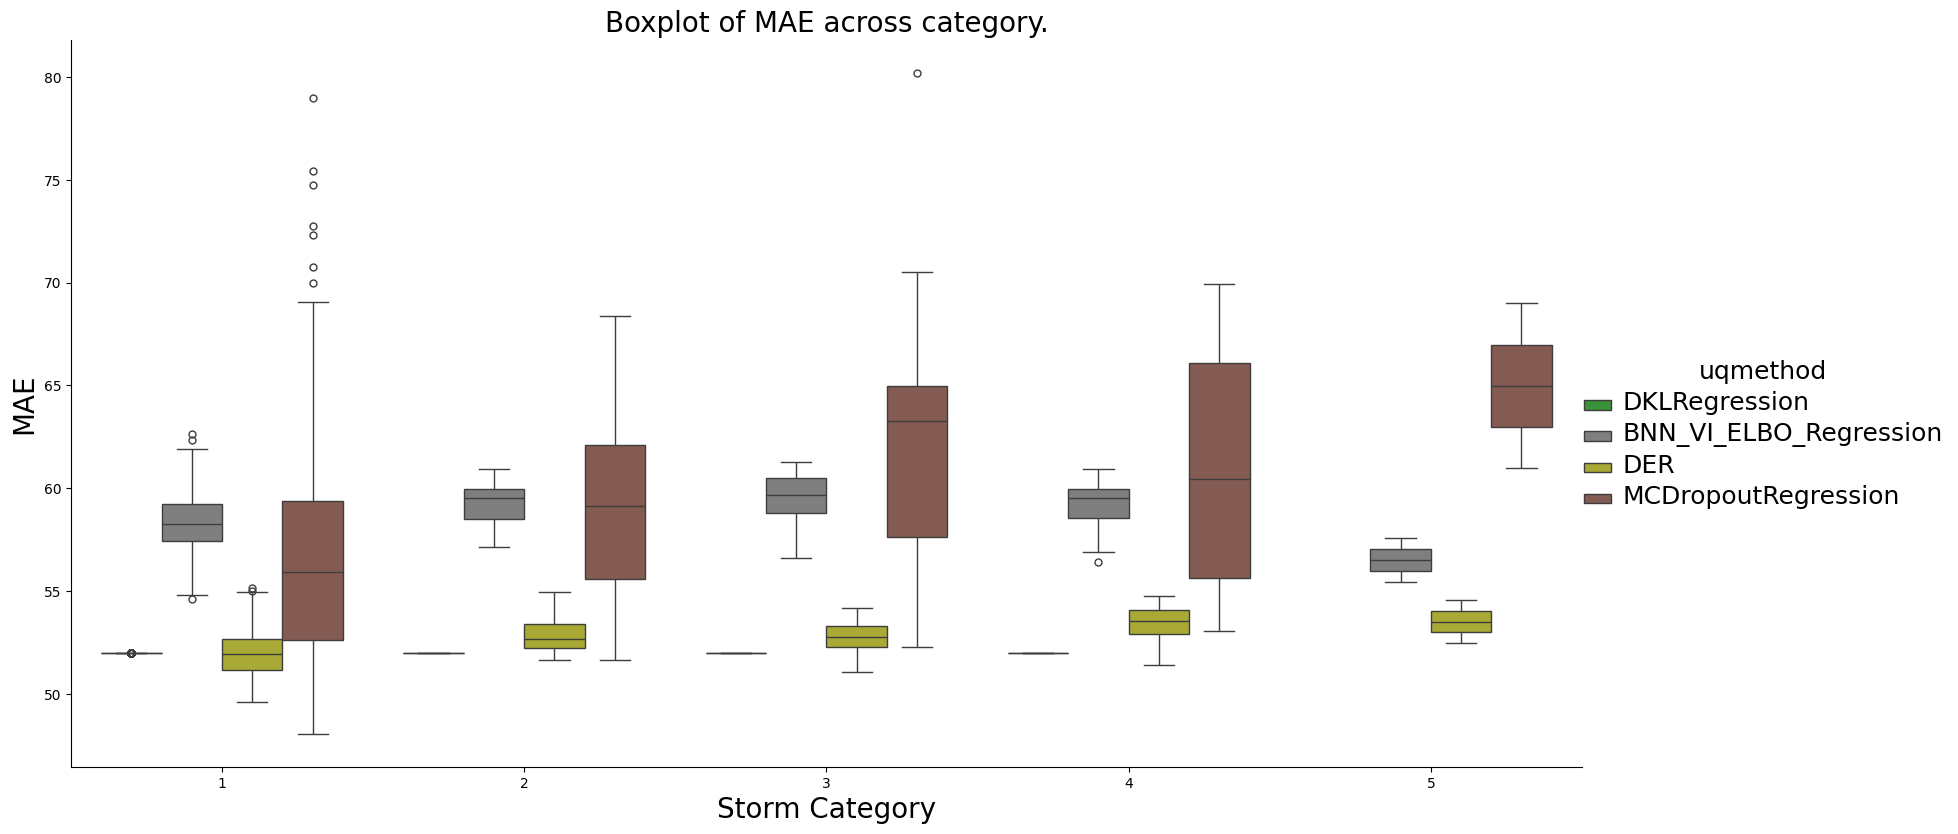

In [99]:
g = sns.catplot(all_test_pred_df[all_test_pred_df["uqmethod"]!="DERModel"], kind="box", x="storm_category", y="pred", hue="uqmethod", height=8, aspect=2, palette=color_palette)

ax = g.ax

# Add horizontal lines behind each x value group
for i, artist in enumerate(ax.artists):
    if i % 2 == 0:  # Check if it's an even index (i.e., group separator)
        artist.set_edgecolor('black')  # Set the edge color to black


# true_test_means = full_df[full_df["split"]=="test"].groupby("storm_category")["wind_speed"].mean().values
# print(true_test_means)
# pos_idx = np.linspace(0.1, 0.9, len(true_test_means))
# # Add additional horizontal lines using axhline
# for i, val in enumerate(true_test_means):
#     print(i, val)
#     ax.axhline(y=val, xmin=pos_idx[i]-0.1, xmax=pos_idx[i]+0.1, color='red', linestyle='--', linewidth=2) 

plt.title("Boxplot of MAE across category.", fontsize=20)
plt.ylabel("MAE", fontsize=20)
plt.xlabel("Storm Category", fontsize=20)
plt.setp(g._legend.get_texts(), fontsize='18') # for legend text
plt.setp(g._legend.get_title(), fontsize='18') # for legend title
g._legend.set_bbox_to_anchor((1.07, 0.5))

# Selective prediction per Storm Category

In [106]:
from sklearn.metrics import mean_squared_error

rmse_all = all_test_pred_df.groupby(['uqmethod', 'storm_category']).apply(lambda x: np.sqrt(mean_squared_error(x['pred'], x['target']))).reset_index()
rmse_all.columns = ['uqmethod', 'storm_category', 'RMSE_All']

# Filter data where uncertainty is less than the threshold
df_filtered = all_test_pred_df[all_test_pred_df['pred_uct'] < SELECTIVE_THRESH]

# Compute RMSE per method and category over filtered predictions
rmse_filtered = df_filtered.groupby(['uqmethod', 'storm_category']).apply(lambda x: np.sqrt(mean_squared_error(x['pred'], x['target']))).reset_index()
rmse_filtered.columns = ['uqmethod', 'storm_category', 'RMSE_Uncertainty_Less_Threshold']

# Merge the two DataFrames on method and category
summary_table = pd.merge(rmse_all, rmse_filtered, on=['uqmethod', 'storm_category'], how='left')

# If there are some categories/methods where no data meets the threshold condition, you might want to replace NaNs with a specific value
summary_table.fillna({'RMSE_Uncertainty_Less_Threshold': np.nan}, inplace=True)

summary_table['pct_change'] = ((summary_table['RMSE_Uncertainty_Less_Threshold'] - summary_table['RMSE_All']) / summary_table['RMSE_All']) * 100
summary_table["abs_change"] = np.abs(summary_table['RMSE_Uncertainty_Less_Threshold'] - summary_table['RMSE_All'])
summary_table['abs_change'] = summary_table['abs_change'].fillna(0)


# Display the summary table
print(summary_table)

/tmp/ipykernel_10267/428305220.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rmse_all = all_test_pred_df.groupby(['uqmethod', 'storm_category']).apply(lambda x: np.sqrt(mean_squared_error(x['pred'], x['target']))).reset_index()
/tmp/ipykernel_10267/428305220.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rmse_filtered = df_filtered.groupby(['uqmethod', 'storm_category']).apply(lambda x: np.sqrt(mean_squared_error(x['pred'], x['target']))).reset_index()


ValueError: cannot insert storm_category, already exists

In [ ]:
hue_order = summary_table["uqmethod"].unique().tolist()
g = sns.catplot(summary_table, kind="bar", x="storm_category", y="RMSE_All", hue="uqmethod", height=8, aspect=2, palette=color_palette, hue_order=hue_order)

ax = g.ax

sns.barplot(summary_table, x="storm_category", y="RMSE_Uncertainty_Less_Threshold", hue="uqmethod", alpha=0.0, ax=ax, hatch="...", hue_order=hue_order)

ax.get_legend().remove()
plt.title("RMSE scores per category. Dotted bars show RMSE after applying selective prediction.", fontsize=20)
plt.ylabel("RMSE", fontsize=20)
plt.xlabel("Storm Category", fontsize=20)

plt.setp(g._legend.get_texts(), fontsize='18') # for legend text
plt.setp(g._legend.get_title(), fontsize='18') # for legend title
g._legend.set_bbox_to_anchor((1.07, 0.5))


NameError: name 'summary_table' is not defined

In [ ]:
# sharpness


rmse_all = all_test_pred_df.groupby(['uqmethod', 'storm_category']).apply(lambda x: np.mean(x["pred_uct"])).reset_index()
rmse_all.columns = ['uqmethod', 'storm_category', 'SHARP_All']

# Filter data where uncertainty is less than the threshold
df_filtered = all_test_pred_df[all_test_pred_df['pred_uct'] < SELECTIVE_THRESH]

# Compute RMSE per method and category over filtered predictions
rmse_filtered = df_filtered.groupby(['uqmethod', 'storm_category']).apply(lambda x: np.mean(x["pred_uct"])).reset_index()
rmse_filtered.columns = ['uqmethod', 'storm_category', 'SHARP_Uncertainty_Less_Threshold']

# Merge the two DataFrames on method and category
summary_table = pd.merge(rmse_all, rmse_filtered, on=['uqmethod', 'storm_category'], how='left')

# If there are some categories/methods where no data meets the threshold condition, you might want to replace NaNs with a specific value
summary_table.fillna({'SHARP_Uncertainty_Less_Threshold': np.nan}, inplace=True)

summary_table['pct_change'] = ((summary_table['SHARP_Uncertainty_Less_Threshold'] - summary_table['SHARP_All']) / summary_table['SHARP_All']) * 100
summary_table["abs_change"] = np.abs(summary_table['SHARP_Uncertainty_Less_Threshold'] - summary_table['SHARP_All'])
summary_table['abs_change'] = summary_table['abs_change'].fillna(0)

In [107]:
hue_order = summary_table[summary_table["uqmethod"]!="DERModel"]["uqmethod"].unique().tolist()
g = sns.catplot(summary_table[summary_table["uqmethod"]!="DERModel"], kind="bar", x="storm_category", y="SHARP_All", hue="uqmethod", height=8, aspect=2, palette=color_palette, hue_order=hue_order)

ax = g.ax

sns.barplot(summary_table, x="storm_category", y="SHARP_Uncertainty_Less_Threshold", hue="uqmethod", alpha=0.0, ax=ax, hatch="...", hue_order=hue_order)

ax.get_legend().remove()
plt.title("Sharpness scores per category. Dotted bars show Sharpness after applying selective prediction.", fontsize=20)
plt.ylabel("Sharpness", fontsize=16)
plt.xlabel("Storm Category", fontsize=16)
plt.setp(g._legend.get_texts(), fontsize='18') # for legend text
plt.setp(g._legend.get_title(), fontsize='18') # for legend title
g._legend.set_bbox_to_anchor((1.07, 0.5))

NameError: name 'summary_table' is not defined

# Calibration

In [108]:
from typing import Union, List, Any
from matplotlib.axes import Axes
from uncertainty_toolbox.metrics_calibration import (
    get_proportion_lists,
    get_proportion_lists_vectorized,
    adversarial_group_calibration,
    miscalibration_area,
    miscalibration_area_from_proportions,
)


def filter_subset(input_list: List[List[Any]], n_subset: int) -> List[List[Any]]:
    """Keep only n_subset random indices from all lists given in input_list.

    Args:
        input_list: list of lists.
        n_subset: Number of points to plot after filtering.

    Returns:
        List of all input lists with sizes reduced to n_subset.
    """
    assert type(n_subset) is int
    n_total = len(input_list[0])
    idx = np.random.choice(range(n_total), n_subset, replace=False)
    idx = np.sort(idx)
    output_list = []
    for inp in input_list:
        outp = inp[idx]
        output_list.append(outp)
    return output_list


# TODO Look up color pallete value
def plot_calibration(
    y_pred: np.ndarray,
    y_std: np.ndarray,
    y_true: np.ndarray,
    split_name: str,
    n_subset: Union[int, None] = None,
    curve_label: Union[str, None] = None,
    vectorized: bool = True,
    exp_props: Union[np.ndarray, None] = None,
    obs_props: Union[np.ndarray, None] = None,
    ax: Union[Axes, None] = None,
    prop_type: str = "interval",
) -> Axes:
    """Plot the observed proportion vs prediction proportion of outputs falling into a
    range of intervals, and display miscalibration area.

    Args:
        y_pred: 1D array of the predicted means for the held out dataset.
        y_std: 1D array of the predicted standard deviations for the held out dataset.
        y_true: 1D array of the true labels in the held out dataset.
        n_subset: Number of points to plot after filtering.
        curve_label: legend label str for calibration curve.
        vectorized: plot using get_proportion_lists_vectorized.
        exp_props: plot using the given expected proportions.
        obs_props: plot using the given observed proportions.
        ax: matplotlib.axes.Axes object.
        prop_type: "interval" to measure observed proportions for centered prediction intervals,
                   and "quantile" for observed proportions below a predicted quantile.
                   Ignored if exp_props and obs_props are provided as inputs.

    Returns:
        matplotlib.axes.Axes object with plot added.
    """
    # Create ax if it doesn't exist
    if ax is None:
        fig, ax = plt.subplots(figsize=(5, 5))

    # Optionally select a subset
    if n_subset is not None:
        [y_pred, y_std, y_true] = filter_subset([y_pred, y_std, y_true], n_subset)

    if (exp_props is None) or (obs_props is None):
        # Compute exp_proportions and obs_proportions
        if vectorized:
            (exp_proportions, obs_proportions) = get_proportion_lists_vectorized(
                y_pred, y_std, y_true, prop_type=prop_type
            )
        else:
            (exp_proportions, obs_proportions) = get_proportion_lists(
                y_pred, y_std, y_true, prop_type=prop_type
            )
    else:
        # If expected and observed proportions are given
        exp_proportions = np.array(exp_props).flatten()
        obs_proportions = np.array(obs_props).flatten()
        if exp_proportions.shape != obs_proportions.shape:
            raise RuntimeError("exp_props and obs_props shape mismatch")

    # Set label
    if curve_label is None:
        curve_label = "Predictor"

    # Plot
    ax.plot([0, 1], [0, 1], "--", c="gray")
    ax.plot(
        exp_proportions, obs_proportions, label=curve_label.replace("Model", ""), c=color_palette[curve_label]
    )  # , c="#1f77b4")
    # ax.fill_between(exp_proportions, exp_proportions, obs_proportions, alpha=0.1)

    # Format plot
    ax.set_xlabel("Predicted Proportion in Interval", fontsize=16)
    ax.set_ylabel("Observed Proportion in Interval", fontsize=16)
    ax.axis("square")

    buff = 0.01
    ax.set_xlim([0 - buff, 1 + buff])
    ax.set_ylim([0 - buff, 1 + buff])

    ax.set_title(f"Avg Calibration {split_name}", fontsize=16)

    # Compute miscalibration area
    miscalibration_area = miscalibration_area_from_proportions(
        exp_proportions=exp_proportions, obs_proportions=obs_proportions
    )

    # Annotate plot with the miscalibration area
    # ax.text(
    #     x=0.95,
    #     y=0.05,
    #     s="Miscalibration area = %.2f" % miscalibration_area,
    #     verticalalignment="bottom",
    #     horizontalalignment="right",
    #     fontsize="small",
    # )

    return ax

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


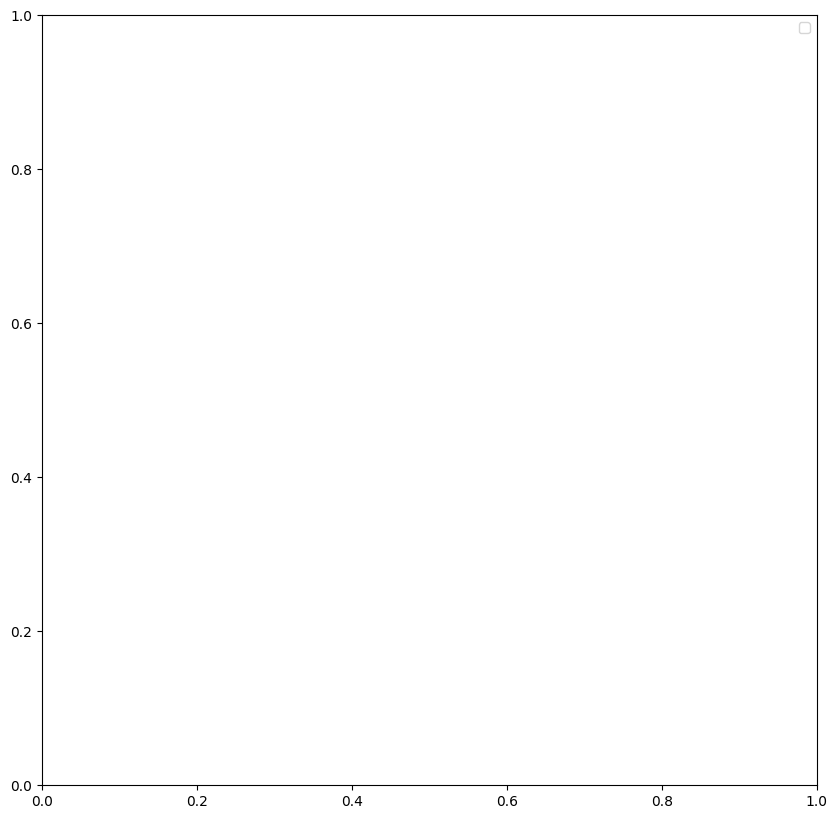

In [109]:
uq_methods_to_show = [
    "DeterministicGaussianModel",
    "DeepEnsembleModel",
    "DeepKernelLearningModel",
    "LaplaceModel",
    "CQR",
    "QuantileRegressionModel",
    "MCDropoutModel",
    "SWAGModel",
    "BNN_VI_ELBO",
    "DERModel",
]

split = "test"

fig, axs = plt.subplots(1, figsize=(10,10))
for idx_uq, uq_method in enumerate(uq_methods_to_show):
    plot_df = uq_metric_df[uq_metric_df["uqmethod"] == uq_method].copy()
    if split == "train":
        plot_df = plot_df[plot_df["split"]=="preds"]
    else:
        plot_df = plot_df[plot_df["split"]=="predictions"]
    plot_df.sort_values(by="split", inplace=True)
    plot_df.reset_index(inplace=True)
    # for idx, pred_path in enumerate(plot_df["pred_path"].unique()):
    for idx, row in plot_df.iterrows():
        split_df = pd.read_csv(row["pred_path"])
        if "pred_uct" in split_df.columns:
            plot_calibration(
                split_df["pred"].values.squeeze(),
                split_df["pred_uct"].values.squeeze(),
                split_df["target"].values.squeeze(),
                ax=axs,
                curve_label=uq_method,
                split_name=split
            )
plt.legend()

# Data Exploration

In [27]:
from lightning_uq_box.datasets import TropicalCycloneTriplet

path = "/p/project/hai_uqmethodbox/data/tropical_cyclone"

train_ds = TropicalCycloneTriplet(root=path, split="train")
test_ds = TropicalCycloneTriplet(root=path, split="test")

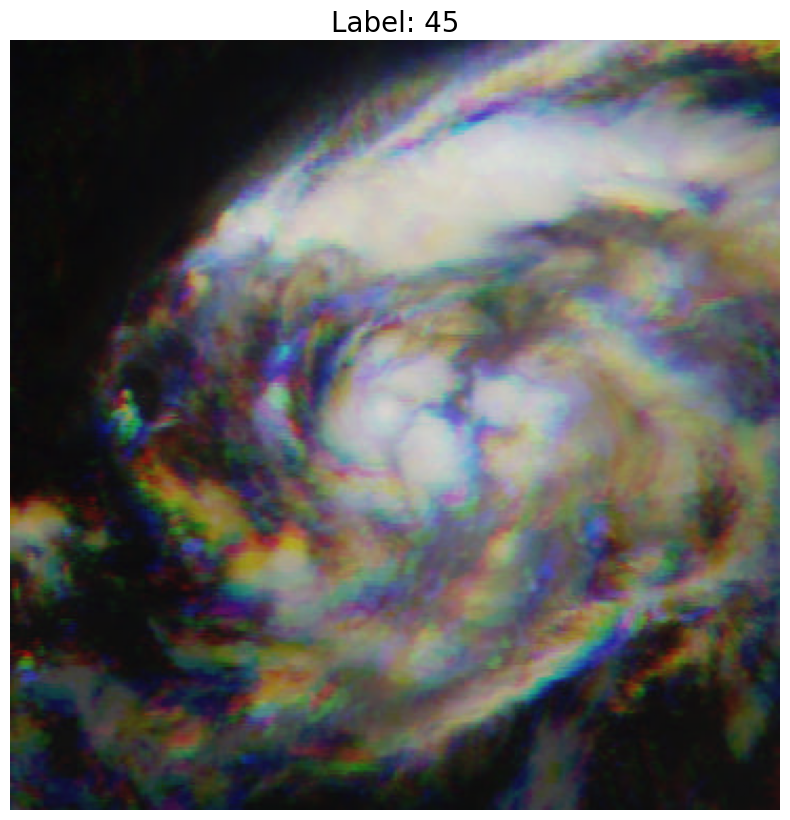

In [28]:
for i in range(len(train_ds)):
    sample = train_ds[i]
    if int(sample["wind_speed"]) > 0:
        train_ds.plot(sample)
        break
# train_ds[0].keys()

In [29]:
def retrieve_item(item, ds):
    source_id = item["href"].split("/")[0]
    if "train_source" in source_id:
        split = "train"
    else:
        split = "test"

    directory = os.path.join(
        ds.root,
        "_".join([train_ds.collection_id, split, "{0}"]),
        source_id.replace("source", "{0}"),
    )
    features = ds._load_features(directory)
    data = {"path": source_id, **features}
    # don't nee the tensor label, already includes 'wind_speed'
    data.pop("label")
    # but add original split where it is coming from
    data["split"] = split
    return data

def retrieve_collection_df(ds):
    def parallel_process(items, ds, num_processes: int):
        # Create a multiprocessing pool with the specified number of processes
        pool = Pool(processes=num_processes)
        # Map the paths to the process_path function and execute in parallel
        read_items = pool.starmap(retrieve_item, [(item, ds) for item in items])
        # Close the pool of processes
        pool.close()
        # Combine the resulting DataFrames into a single DataFrame
        df = pd.DataFrame.from_dict(read_items)
        return df
    
    # Specify the number of processes to use for parallel execution
    num_processes = 8  # Adjust according to your system capabilities
    items = [item for item in ds.collection]
    # Call the parallel_process function to execute the processing in parallel
    df = parallel_process(items, ds, num_processes)

    return df

In [30]:
train_df = retrieve_collection_df(train_ds)
test_df = retrieve_collection_df(test_ds)

In [31]:
full_df = pd.concat([train_df, test_df], ignore_index=True)
full_df["wind_speed"] = full_df["wind_speed"].astype(int)

full_df['storm_category'] = pd.cut(full_df['wind_speed'], bins=bins, labels=labels, right=False)
full_df
                     

ValueError: Bin labels must be one fewer than the number of bin edges

## Wind Speed across splits

Text(0.5, 1.0, 'Wind Speed for train and test split.')

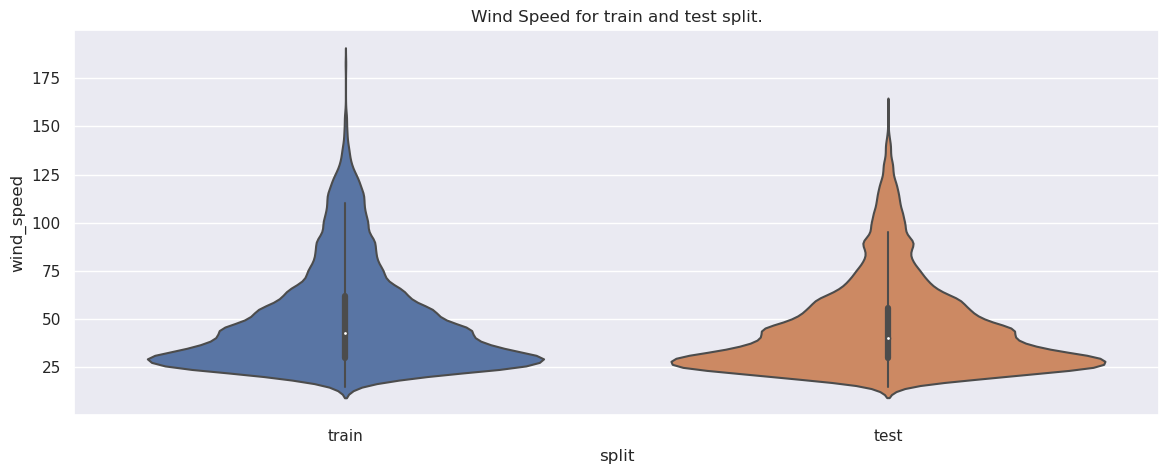

In [ ]:
fig, axs = plt.subplots(1)
sns.violinplot(full_df, x="split", y="wind_speed", ax=axs)
axs.set_title("Wind Speed for train and test split.")

## Wind Speed across categories

Text(0.5, 1.0, 'Boxplot of wind speeds across category and split')

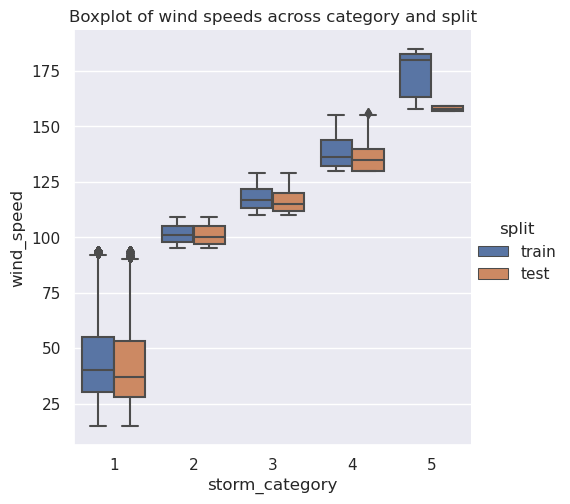

In [ ]:
# fig, axs = plt.subplots(1)
sns.catplot(full_df, kind="box", x="storm_category", y="wind_speed", hue="split")
plt.title("Boxplot of wind speeds across category and split")

Text(0.5, 1.0, 'Count samples per storm category')

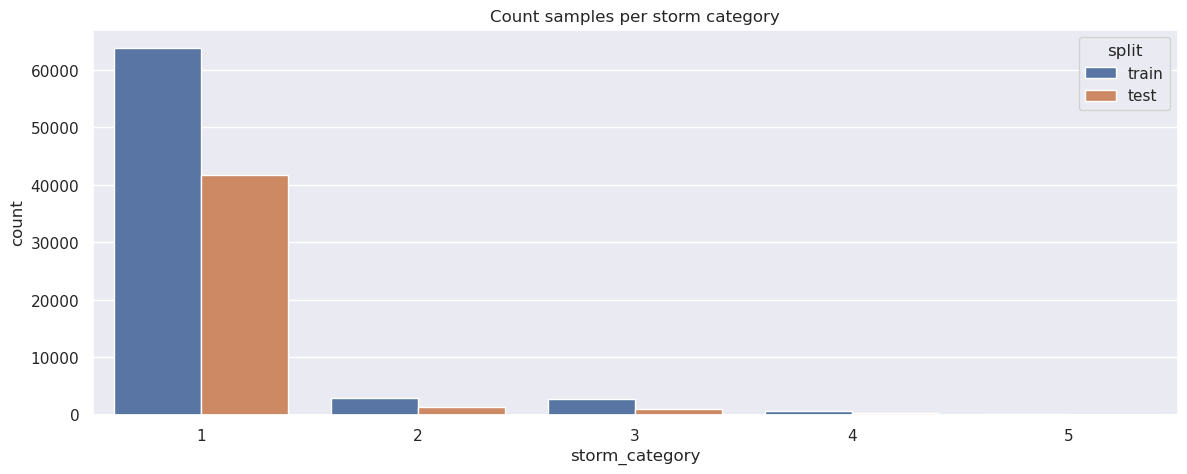

In [ ]:
fig, axs = plt.subplots(1)
sns.countplot(full_df, x="storm_category", hue="split", ax=axs)
plt.title("Count samples per storm category")

In [ ]:
train_df["wind_speed"].astype(int).values

array([34, 34, 34, ..., 45, 45, 45])

In [ ]:
from denseweight import DenseWeight
import numpy as np
import torch

targets = (train_df["wind_speed"].astype(float).values - TARGET_MEAN) / TARGET_STD
dw = DenseWeight(alpha=1.0)
weights = dw.fit(targets)


curr_weight = dw(torch.Tensor([0.1]))
type(curr_weight)


numpy.ndarray

In [ ]:
np.save("/p/project/hai_uqmethodbox/nils/lightning-uq-box/experiments/image-regression/configs/tropical_cyclone/targets.npy", (train_df["wind_speed"].astype(float).values - TARGET_MEAN) / TARGET_STD)